# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Introduction
In this project german traffic signs should be classified. In the following section I present details about my pipeline including:
- Exploration and visualization of the data
- Design and Test a Model Architecture 
    1. Data augmentation
    2. Data preprocessing
    3. Model architecture
- Train, Validate and Test the model
- Performance analysis



##  Load The Data
The data is loaded from the different files and training, validation and test sets are defined.

In [1]:
import pickle 
from sklearn.utils import shuffle
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import csv
import glob
from dask.array.chunk import keepdims_wrapper

# Adjust file names
trainingFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/train.p"
validationFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/valid.p"
testingFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/Dataset/traffic-signs-data/test.p"
modelFile = 'D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop'
newImagesFiles = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/SampleSigns/*.png"
signNamesFile = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/signnames.csv"

def ReadData(file):
    with open(file, mode='rb') as f:
        data = pickle.load(f)
        features, labels = data['features'], data['labels']
    assert(len(features) == len(labels))
    return features, labels


'''
Reading the data
'''
featuresTraining, labelsTraining = ReadData(trainingFile)
featuresValidation, labelsValidation = ReadData(validationFile)
featuresTesting, labelsTesting = ReadData(testingFile)


---

## Dataset summary & exploration

This section consists of a basic summary of the data set and a visualization of the data sets.

### Basic summary of the data set

In [2]:


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(labelsTraining)
# TODO: Number of validation examples
n_validation = len(labelsValidation)
# TODO: Number of testing examples.
n_test = len(labelsTesting)
# TODO: What's the shape of an traffic sign image?
image_shape = featuresTraining[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Sample data

In this section I show one randomly choosen sample of each sign class. In addition I show the distribution of the data samples over the 43 sign classes for training, validation and testing set. 


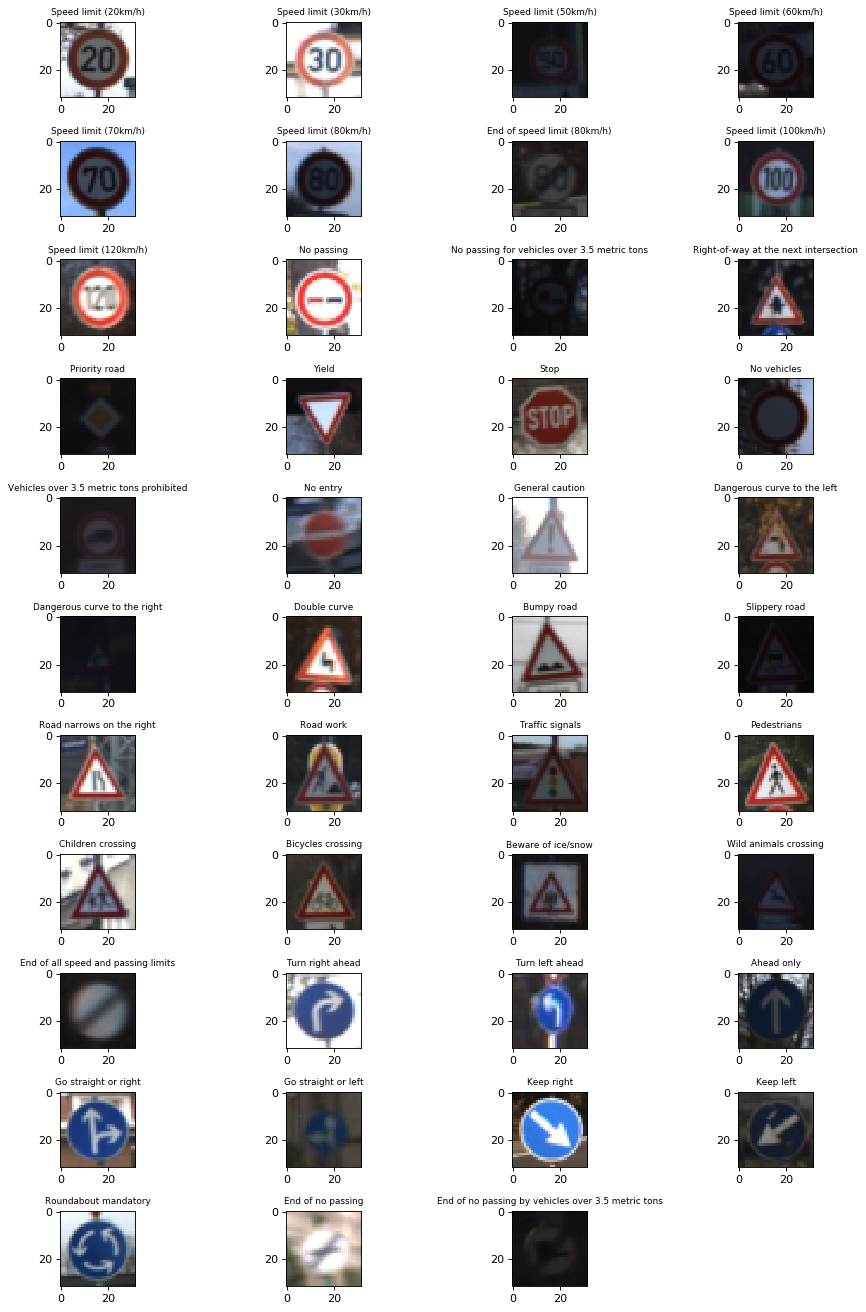

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
def ShowSampleData(features, labels):
    labelNames = {}
    with open(signNamesFile, mode='r') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        for row in csvReader:
            if row[0].isdigit():
                labelNames[int(row[0])] = row[1]
    plt.figure(figsize=(12, 16.5), dpi =80)
    for signID, signName in labelNames.items():
        plt.subplot(11, 4, 1+signID)
        selectedFeatures = features[labels == signID]
        randomize = np.random.randint(0,100)
        plt.imshow(selectedFeatures[randomize,:,:,:])
        plt.tight_layout()
        plt.title(signName, fontsize = 8)


ShowSampleData(featuresTraining, labelsTraining)
    



### Data visualization
The following code shows the data distributed over the 43 sign classes. I show a histogram for training, validation and testing data set followed by a short discussion.

training labels


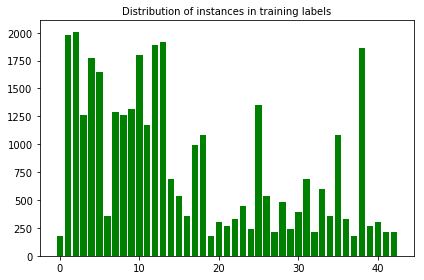

validation labels


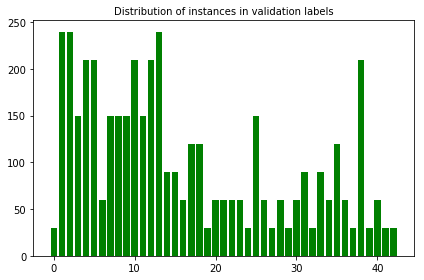

testing labels


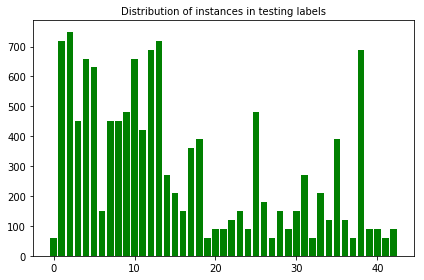

In [4]:
def DataExploration(y, name):
    result = np.unique(y, return_counts =True)
    assert(len(result[1]) == 43)
    print (name)
#    print(np.vstack((result[0], result[1])).T)
    plt.bar(result[0], result[1], 0.8, color = 'green')
    plt.title('Distribution of instances in '+name, fontsize=10)
    plt.tight_layout()
    plt.show()

    
DataExploration(labelsTraining, "training labels")
DataExploration(labelsValidation, "validation labels")
DataExploration(labelsTesting, "testing labels")


From the above histograms it is obvious that the data is far from equally distributed. This might represent the relative frequency of the traffic signs on German roads and it is no problem for validation and testing set. For particular traffic signs we have less than 200 instances in the training data set, which might be to less to train the model 
Therefore data augmentation as in [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) will be performed below.


----

##  Design and Test a Model Architecture

I follow the example in  [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). After experimenting with several different setup my final pipeline consists of three steps:
1. Data augmentation to increase sample size of underrepresented classes in the training data set
2. Data preprocessing to improve performance
3. Exploring and adjusting the LeNet model to improve performance

### Data Augmentation
At the end of Step1, we found that the data is not equally distributed and several traffic sign classes are underrepresented in the training, validation and testing set. Therefore in this section three methods (image rotation, image translation, image rescaling) are implemented which increase the number of data sets in the training data set based on the original training data set. We followed closely the suggested parameters in the baseline model and if not stated otherwise we use the following setup for data augmentation.
- Rotation was performed using a random angle between -15.0 and +15.0 degrees
- Translation was performed randomly for width/height changes in the range of -2 to +2 pixels
- Rescaling was performed for width and height using one random scaling factor between 0.8 and 1.2

For each sign instance at least 1000 sample have been required. (In an experiment 10000 samples for each sign class using an extended parameter space (rotations: -25/+25 degrees, translations: -4/+4 pixels, no rescaling) have been generated. No significant improvement of the model was observed.) The underlying images to generate the additional samples have been chosen randomely from the training data set only.

Relative frequency required for each class in whole set: 1000
Training labels after data augmentation


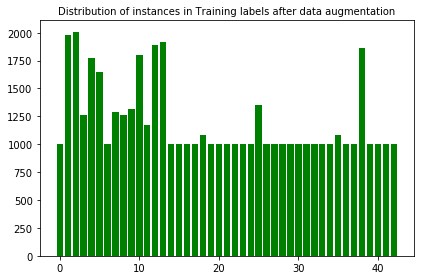

In [5]:
def ApplyImageRotation(image, angle):
    imageCenterWidth =image.shape[0]//2
    imageCenterHeight =image.shape[1]//2
    rotationMatrix = cv2.getRotationMatrix2D((imageCenterWidth, imageCenterHeight),angle,1)
    return cv2.warpAffine(image,rotationMatrix,(image.shape[0],image.shape[1]))   

def ApplyImageTranslation(image, translation):
    translationMatrix = np.float32([[1,0,translation[0]],[0,1,translation[1]]])
    return cv2.warpAffine(image,translationMatrix,(image.shape[0],image.shape[1]))

# we apply the same scaling factor to width and height to keep the square format
def ApplyImageRescaling(image, scalingFactor):
    imageWidth = image.shape[0]
    imageHeight = image.shape[1]
    newImage = cv2.resize(image,(0,0), fx=scalingFactor, fy=scalingFactor)
    newImageWidth = newImage.shape[0]
    diffWidth = imageWidth-newImageWidth
    # No scaling applied
    if(diffWidth ==0):
        newImage = image
    #New image is smaller than original, take black image and copy new image into the black one
    elif(diffWidth > 0):
        blankImage = np.zeros((imageWidth,imageHeight,3), np.uint8)
        maxOffset = diffWidth
        offsetWidth = np.random.randint(0,maxOffset)
        offsetHeight = np.random.randint(0,maxOffset)
        blankImage[offsetWidth:offsetWidth+newImageWidth, offsetHeight:offsetHeight+newImageWidth] = newImage
        newImage = blankImage
    #New image is larger than original, take a random part
    else:
        maxOffset = -diffWidth
        offsetWidth = np.random.randint(0,maxOffset)
        offsetHeight = np.random.randint(0,maxOffset)
        newImage = newImage[offsetWidth:offsetWidth+imageWidth, offsetHeight:offsetHeight+imageWidth]
    
    assert(newImage.shape == image.shape)
    return newImage



def TransformImage(image):
    angle = np.random.uniform(-15,15)
    translation = np.random.randint(-2,2,2)
    scalingFactor = np.random.uniform(0.8,1.2)
    
    rotatedImage = ApplyImageRotation(image, angle)
    translatedImage = ApplyImageTranslation(rotatedImage, translation)
    scaledImage = ApplyImageRescaling(translatedImage, scalingFactor)
    return scaledImage
      

def GenerateNewData(numberOfDataSets, underlyingImages, assignedLabel):
    generatedImageSamples = np.random.randint(len(underlyingImages), size = numberOfDataSets)
    newImages = []
    newLabels = [assignedLabel]*numberOfDataSets
    for index in generatedImageSamples:
        newImages.append(TransformImage(underlyingImages[index]))
    return newImages, newLabels



def DataAugmentation(features, labels, requiredInstancesPerSign):
    trafficSigns, trafficSignCounts = np.unique(labels, return_counts=True)
    SignsAndCounts = dict(zip(trafficSigns, trafficSignCounts))
    print( "Relative frequency required for each class in whole set: "+ repr(requiredInstancesPerSign)) 
    for signID, signCount in SignsAndCounts.items():
        if(signCount > requiredInstancesPerSign):           
            continue
        numberOfInstancesToGenerate = requiredInstancesPerSign - signCount
        featuresForNewInstanceGeneration = features[labels == signID]
        
        newImages, newLabels = GenerateNewData(numberOfInstancesToGenerate, featuresForNewInstanceGeneration,signID)
        assert(len(newLabels) == len(newImages))
        
        newImages = np.asarray(newImages, dtype=features.dtype)    
        newLabels = np.asarray(newLabels, dtype=labels.dtype)
        features = np.append(features, newImages, axis=0)
        labels = np.append(labels, newLabels, axis=0)
    return features, labels



featuresTraining, labelsTraining = DataAugmentation(featuresTraining, labelsTraining, requiredInstancesPerSign =1000)

DataExploration(labelsTraining, "Training labels after data augmentation")

In [6]:
n_train = len(labelsTraining)
# TODO: Number of validation examples
print("Number of training examples after data augmentation =", n_train)

Number of training examples after data augmentation = 51690


### Pre-process the Data Set (normalization, grayscale, etc.)

I applied three steps according to the published baseline model:
1. Switch to color space. Here I tried the HSV color space first (known from the former project) but found that the suggested    Y component from the YUV color space yields better results.
2. To improve the contrast of each image an histogram equalization was applied.
3. I normalized the data using the data sets mean and its standard deviation.

I also tried to reduce noise in the images using various functions provided by OpenCV but I did not find a significant increase of the model accuracy.

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Extract V from HSV space (gray image)
def ConvertImageToHSVSpace(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def ExtractV(image):
    _,_,v = cv2.split(ConvertImageToHSVSpace(image))    
    return v

# Extract Y from YUV space (gray image)
def ConvertImageToYUVSpace(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
def ExtractY(image):
    y,_,_ = cv2.split(ConvertImageToYUVSpace(image))    
    return y

def ImageFeaturesPreProcessing(inputImages, YUV = True, imageWeight = 1.5, noiseWeight = -0.8):
    numberOfImages = inputImages.shape[0] 
    imageWidth = inputImages.shape[1] 
    imageHeight = inputImages.shape[2] 
    resultingImages = np.ndarray((numberOfImages, imageWidth, imageHeight, 1), dtype=np.uint8)
    for index, image in enumerate(inputImages):
        if(YUV):
            '''
            Use YUV color space
            '''
            image = ExtractY(image)
        else:
            '''
            Use HSV color space
            '''
            image = ExtractV(image)
        image = cv2.equalizeHist(image)
        image = np.expand_dims(image, axis=2)
        resultingImages[index] = image
    return resultingImages


# Normalize the data set
def NormalizeData(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/std

'''
Preprocess all images
'''
featuresTraining = ImageFeaturesPreProcessing(featuresTraining)
featuresValidation = ImageFeaturesPreProcessing(featuresValidation)
featuresTesting = ImageFeaturesPreProcessing(featuresTesting)

'''
Normalize data
'''
featuresTraining = NormalizeData(featuresTraining)
featuresValidation = NormalizeData(featuresValidation)
featuresTesting = NormalizeData(featuresTesting)


### Model Architecture
In a first step I used the original LeNet architecture and made minimal adjustments regarding input shape (width, height and depth) and output depth. Using the following notation convention:
- Filter shape: (width, height, input depth, output depth)
- Input/Output shape: (width, height, input/output depth)

I used the following model in the beginning:

1. Convolution layer 1:
    - Input shape: (32,32,1)
    - Output shape:  (28,28,6)
    - Filter shape: (5, 5, 1, 6)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
2. Activation function 1: 
    - Function: Relu
    - Pooling: Valid
3. Pooling layer 1: 
    - Input shape: (28,28,6)
    - Output shape: (14,14,6)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
4. Convolution layer 2:
    - Input shape: (14,14,6)
    - Output shape:  (10,10,16)
    - Filter shape: (5,5,6,16)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
5. Activation function 2: 
    - Function: Relu
    - Pooling: Valid
6. Pooling layer 2:
    - Input shape: (10,10,16)
    - Output shape: (5,5,16)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
7. Flatten layer 1:
    - Input shape: (5,5,16)
    - Output shape: 400
8. Fully connected layer 1:
    - Input shape: 400
    - Output shape: 120
9. Activation function 3: 
    - Function: Relu
    - Pooling: Valid
10. Fully connected layer 2:
    - Input shape: 120
    - Output shape: 84
11. Activation function 4: 
    - Function: Relu
    - Pooling: Valid
12. Fully connected layer 3:
    - Input shape: 84
    - Output shape: 43



I found that these setup results in validation accurcay above 90% but not above 93 percent. I investigated some simple extensions and found the following architecture achieves a 93 % validation accurcay:

1. Convolution layer 1:
    - Input shape: (32,32,1)
    - Output shape:  (28,28,6)
    - Filter shape: (5, 5, 1, 6)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
2. Activation function 1: 
    - Function: Relu
    - Pooling: Valid
3. Pooling layer 1: 
    - Input shape: (28,28,6)
    - Output shape: (14,14,6)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
4. Convolution layer 2:
    - Input shape: (14,14,6)
    - Output shape:  (10,10,16)
    - Filter shape: (5,5,6,16)
    - Stride shape: (1,1,1,1)
    - Pooling: Valid
5. Activation function 2: 
    - Function: Relu
    - Pooling: Valid
6. Pooling layer 2:
    - Input shape: (10,10,16)
    - Output shape: (5,5,16)
    - Filter shape: (1,2,2,1)
    - Stride shape: (1,2,2,1)
    - Pooling: Valid
7. Flatten layer 1:
    - Input shape: (5,5,16)
    - Output shape: 400
8. Fully connected layer 1:
    - Input shape: 400
    - Output shape: 120
9. Activation function 3: 
    - Function: Relu
    - Pooling: Valid
10. Dropout function 1: 
    - Keep-Probability: 50%
11. Fully connected layer 2:
    - Input shape: 120
    - Output shape: 84
12. Activation function 4: 
    - Function: Relu
    - Pooling: Valid
13. Dropout function 2: 
    - Keep-Probability: 50%
14. Fully connected layer 3:
    - Input shape: 84
    - Output shape: 43

With this setup and the setup for data augmenation and data processing I investigated the performance of the architecture. Therefore I only altered the parameters 
- Learning rate 
- Number of epochs 
- Batch size 

The final architecture is shown in the next cell.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(input, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
  
    weightsLayer1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean = mu, stddev =sigma))
    biasLayer1 = tf.Variable(tf.zeros(6))
    paddingLayer1 = 'VALID'
    stridesLayer1 = [1,1,1,1]
    layer1 =  tf.nn.conv2d(x,weightsLayer1, stridesLayer1, paddingLayer1) + biasLayer1
    # TODO: Activation.
    activation1 = tf.nn.relu(layer1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    filterPooling1 = [1,2,2,1]
    stridesPooling1 = [1,2,2,1]
    paddingPooling1 = 'VALID'
    maxPooling1 = tf.nn.max_pool(activation1, filterPooling1, stridesPooling1, paddingPooling1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    weightsLayer2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev =sigma))
    biasLayer2 = tf.Variable(tf.zeros(16))
    paddingLayer2 = 'VALID'
    stridesLayer2 = [1,1,1,1]
    layer2 =  tf.nn.conv2d(maxPooling1,weightsLayer2, stridesLayer2, paddingLayer2) + biasLayer2
    
    # TODO: Activation.
    activation2 = tf.nn.relu(layer2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    filterPooling2 = [1,2,2,1]
    stridesPooling2 = [1,2,2,1]
    paddingPooling2 = 'VALID'
    maxPooling2 = tf.nn.max_pool(activation2, filterPooling2, stridesPooling2, paddingPooling2)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flatten1 = flatten(maxPooling2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    filter3 = [400,120]
    weightsLayer3 = tf.Variable(tf.truncated_normal(filter3, mean = mu, stddev =sigma))
    biasLayer3 = tf.Variable(tf.zeros(120))
    layer3 = tf.matmul(flatten1, weightsLayer3) + biasLayer3
    
    
    # TODO: Activation.
    activation3 = tf.nn.relu(layer3)
    activation3 = tf.nn.dropout(activation3, keep_prob)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    filter4 = [120,84]
    weightsLayer4 = tf.Variable(tf.truncated_normal(filter4, mean = mu, stddev =sigma))
    biasLayer4 = tf.Variable(tf.zeros(84))
    layer4 = tf.matmul(activation3, weightsLayer4) + biasLayer4
    
   
    # TODO: Activation.
    activation4 = tf.nn.relu(layer4)
    activation4 = tf.nn.dropout(activation4, keep_prob)
   
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    filter5 = [84,43]
    weightsLayer5 = tf.Variable(tf.truncated_normal(filter5, mean = mu, stddev =sigma))
    biasLayer5 = tf.Variable(tf.zeros(43))
    layer5 = tf.matmul(activation4, weightsLayer5) + biasLayer5
    
    return layer5


### Train, Validate and Test the Model

The following table documents the performance of the adjusted LeNet architecture varying the paramters:
- Learning rate
- Batch size
- Number of epochs

The next to last column shows the validation accuracy in the last epoch. The last column shows the maximum accuracy over all epochs and its deviation might indicate overfitting. Note, that here all other paramters are fixed (see e.g. data augmentation) to the choosen default values. It is far from obvious if a best choice for learning rate, batch size and epoch count exists in this setup. 
From the table we choose the following parameter values if not stated otherwise:

- Learning rate: 0.001
- Batch size: 128
- Number of epochs: 20



|              |           |        |                        |                 | 
|--------------|-----------|--------|------------------------|-----------------| 
| LearningRate | BatchSize | Epochs | Validation accurcay    | Maximum accuracy| 
|              |           |        |                        |                 | 
|              |           |        |                        |                 | 
| 0.001        | 128       | 20     | 97.12018141            | 97.12018141     | 
|              |           |        |                        |                 | 
| 0.001        | 64        | 20     | 96.75736957            | 97.02947841     | 
|              |           |        |                        |                 | 
| 0.001        | 256       | 20     | 95.39682537            | 95.39682537     | 
|              |           |        |                        |                 | 
| 0.001        | 32        | 20     | 96.93877555            | 96.93877555     | 
|              |           |        |                        |                 | 
| 0.0001       | 128       | 20     | 87.09750564            | 87.09750564     | 
|              |           |        |                        |                 | 
| 0.0001       | 128       | 50     | 91.06575959            | 91.3151927      | 
|              |           |        |                        |                 | 
| 0.00025      | 128       | 50     | 96.46258493            | 96.80272104     | 
|              |           |        |                        |                 | 
| 0.0005       | 128       | 50     | 96.37188211            | 97.07482993     | 
|              |           |        |                        |                 | 
| 0.0005       | 128       | 20     | 95.69160993            | 95.71428567     | 
|              |           |        |                        |                 | 
| 0.00075      | 128       | 20     | 96.28117914            | 96.28117914     | 
|              |           |        |                        |                 | 
| 0.0025       | 128       | 20     | 97.41496601            | 97.70975059     | 
|              |           |        |                        |                 | 
| 0.0025       | 64        | 15     | 97.46031739            | 97.46031739     | 
|              |           |        |                        |                 | 
| 0.005        | 128       | 10     | 95.2154195             | 95.2154195      | 
|              |           |        |                        |                 | 
| 0.005        | 128       | 15     | 94.80725626            | 94.80725626     | 
|              |           |        |                        |                 | 
| 0.0075       | 128       | 15     | 89.63718817            | 90.3174603      | 
|              |           |        |                        |                 | 
| 0.0075       | 64        | 20     | 83.15192742            | 83.15192742     | 
|              |           |        |                        |                 | 
| 0.01         | 128       | 20     | 81.70068029            | 83.60544216     | 
|              |           |        |                        |                 | 
| 0.001        | 128       | 20     | 96.05442169            | 96.16780043     | 
|              |           |        |                        |                 | 
| 0.001        | 64        | 20     | 96.23582769            | 97.00680272     | 


With the values choosen above we train, validate and finally test the model.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
BATCH_SIZE = 128
EPOCHS = 20
learningRate = 0.001

''' Shuffle training data since training data is ordered'''
featuresTraining, labelsTraining = shuffle(featuresTraining, labelsTraining)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)


logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)    
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def AccuracyAnalysis(epoch, trainingAccuracy ,currentAccuracy, formerAccuracy, maximumAccuracy):
        print("EPOCH {} ...".format(epoch + 1))
        print("Training Accuracy [%] = {:.5f}".format(trainingAccuracy*100.0))
        print("Validation Accuracy [%] = {:.5f}".format(currentAccuracy*100.0))
        if(currentAccuracy > maximumAccuracy):
            maximumAccuracy = currentAccuracy

        if(formerAccuracy > 0.0):
            print("Relative change of validation accuracy [%] = {:.5f}".format((currentAccuracy - formerAccuracy)/formerAccuracy*100.0))
        if(maximumAccuracy > 0.0):
            print("Current validation accuracy in terms of maximum validation accuracy = {:.5f}".format(currentAccuracy/maximumAccuracy))
        print()
        formerAccuracy = currentAccuracy
        return formerAccuracy, maximumAccuracy
        

def evaluate(featuresData, labelsData):
    numberOfDataSets = len(featuresData)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, numberOfDataSets, BATCH_SIZE):
        batch_x, batch_y = featuresData[offset:offset + BATCH_SIZE], labelsData[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / numberOfDataSets



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    numberOfDataSets = len(featuresTraining)
    print("Training...")
    print()
    formerValidationAccuracy = 0.0
    maximumValidationAccuracy = 0.0
    for epoch in range(EPOCHS):
        featuresTraining, labelsTraining = shuffle(featuresTraining, labelsTraining)
        for offset in range(0, numberOfDataSets, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = featuresTraining[offset:end], labelsTraining[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        currentValidationAccuracy = evaluate(featuresValidation, labelsValidation)
        currentTrainingAccuracy = evaluate(featuresTraining, labelsTraining)
        
        formerValidationAccuracy, maximumValidationAccuracy = AccuracyAnalysis(epoch, currentTrainingAccuracy, currentValidationAccuracy, formerValidationAccuracy, maximumValidationAccuracy)
        
    saver.save(sess, modelFile)
    print("Model saved")



Training...

EPOCH 1 ...
Training Accuracy [%] = 69.10621
Validation Accuracy [%] = 72.29025
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 2 ...
Training Accuracy [%] = 81.28458
Validation Accuracy [%] = 86.59864
Relative change of validation accuracy [%] = 19.79297
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 3 ...
Training Accuracy [%] = 85.20217
Validation Accuracy [%] = 88.66213
Relative change of validation accuracy [%] = 2.38282
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 4 ...
Training Accuracy [%] = 88.65545
Validation Accuracy [%] = 92.08617
Relative change of validation accuracy [%] = 3.86189
Current validation accuracy in terms of maximum validation accuracy = 1.00000

EPOCH 5 ...
Training Accuracy [%] = 90.71000
Validation Accuracy [%] = 93.83220
Relative change of validation accuracy [%] = 1.89608
Current validation accuracy in terms of maximum validation

In [10]:
#Run testing
with tf.Session() as sess:
    saver.restore(sess, modelFile)
    test_accuracy = evaluate(featuresTesting, labelsTesting)
    print("Accuracy for testing = {:.5f}".format(test_accuracy))



INFO:tensorflow:Restoring parameters from D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop
Accuracy for testing = 0.94671


The model performs well on the test data with an accuracy of about 94%. 

---

##  Test a Model on New Images

I used Google Street View to get more pictures of traffic signs. The model, is used to 

### Predict the Sign Type for Each Image
The following code loads the the stored model and loads 12 rgb images of size (32,32) taken from Google Street View.
All images are preprocessed and normalized before they are given to the stored model. The images, their correct label, their predicted label and the top 5 predictions for each image. 


INFO:tensorflow:Restoring parameters from D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop
12


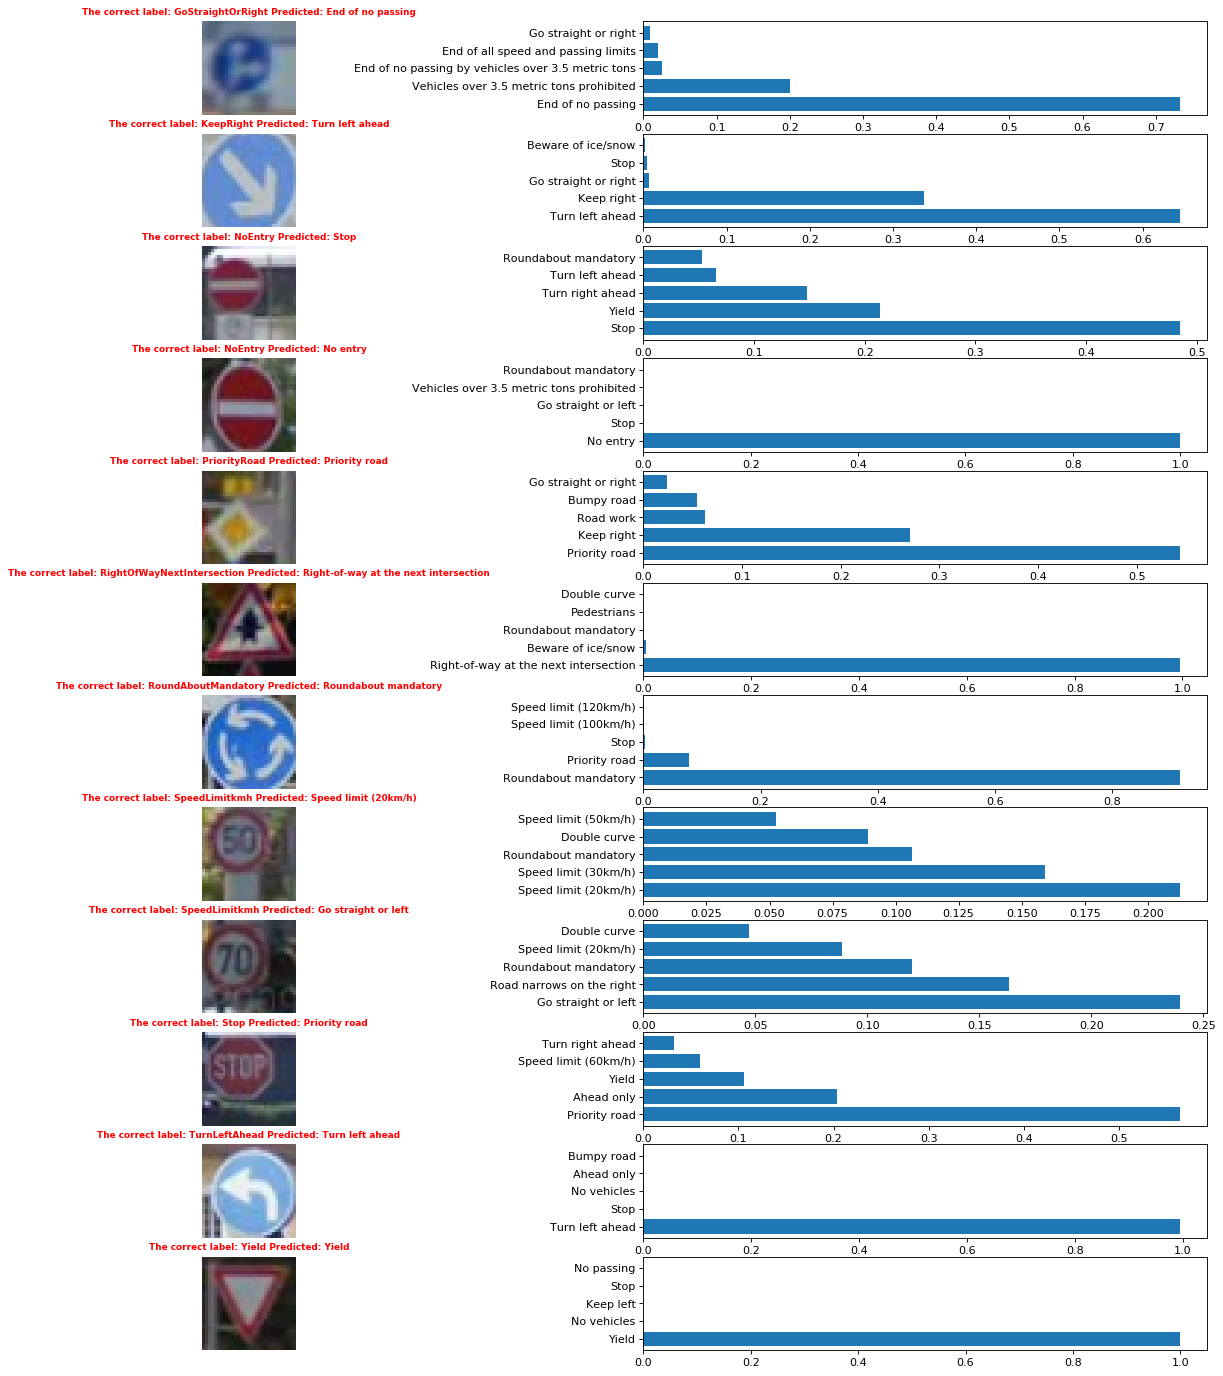

In [11]:
def PredictTestImages(features, session):
    features = ImageFeaturesPreProcessing(features)
    features = NormalizeData(features)
    probabilities = sess.run(tf.nn.softmax(logits), feed_dict={x: features, keep_prob: 1.0}) 
    top5Probabilities = tf.nn.top_k(probabilities, k=5)
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: features, keep_prob: 1.0})
    return predictions, session.run(top5Probabilities)
 

def ApplyModelToSampleImages(session):
    sampleImageFiles = [path for path in glob.glob(newImagesFiles)]
    imageCount = len(sampleImageFiles)
    print (imageCount)
    sampleImages = np.uint8(np.zeros((imageCount,32,32,3)))
    #saver.restore(session, './Project2/CarND-Traffic-Sign-Classifier-Project/Model/LeNetWithDrop')
    
    labelNames = {}
    with open(signNamesFile, mode='r') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        for row in csvReader:
            if row[0].isdigit():
                labelNames[int(row[0])] = row[1]

    for index, imageFile in enumerate(sampleImageFiles):
        image=cv2.imread(imageFile)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sampleImages[index] = image
#        plt.subplot(3, 2, 1+index)
#        plt.imshow(image)
#        plt.tight_layout()
#        plt.title(index, fontsize = 8)
    predictions, top5Probabilities = PredictTestImages(sampleImages, session)
    plt.figure(figsize=(20, 22), dpi=80)
    for i in range(imageCount):
        plt.subplot(imageCount, 2, 2*i+1)
        plt.imshow(sampleImages[i]) 
        title = sampleImageFiles[i].split('\\')[-1].split('.')[0]
        title = ''.join([char for char in title if not char.isdigit()])
        title = "The correct label: " + title + " Predicted: " + labelNames[predictions[i]]
        plt.title(title, color ='red', weight = 'bold', fontsize = 8)
        plt.axis('off')
        plt.subplot(imageCount, 2, 2*i+2)
        plt.barh(np.arange(1, 6, 1), top5Probabilities.values[i, :])
        labs=[labelNames[j] for j in top5Probabilities.indices[i]]
        plt.yticks(np.arange(1, 6, 1), labs)
    plt.show()
    
with tf.Session() as sess:
    saver.restore(sess, modelFile)
    ApplyModelToSampleImages(sess)


### Analyze Performance

The performance of the model is not good. Only 50% of the signs have been predicted correctly, which is far below of the expected performance of the test set (94 %). In my eclipse implementation I rerun the analysis by traininig the model using different data augmentation parameters and larger data sets (not using the test data). I could not get an conclusive result how to improve the situation. In particular each time the signs which were identified correctly changed. Only the identification of the last two signs (yield and turn-left-ahead) seems to work quite well, while the speed limit signs seem to be quite a challenge for my model.